# Carga de datos

In [1]:
#Descarga
!wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
unzip:  cannot find or open FullIJCNN2013.zip, FullIJCNN2013.zip.zip or FullIJCNN2013.zip.ZIP.


In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

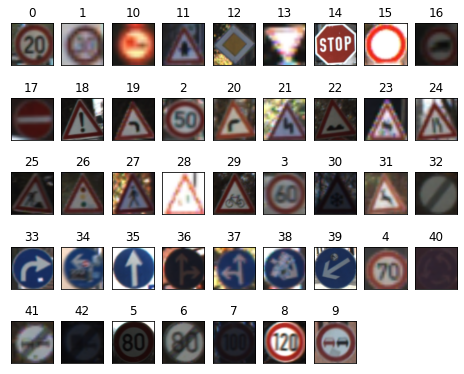

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
from sklearn.utils import shuffle
from skimage.transform import resize

train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
print(tr_signs[0].shape)
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

tr_signs_res = np.zeros((len(tr_signs),48,48,3))
va_signs_res = np.zeros((len(va_signs),48,48,3))
te_signs_res = np.zeros((len(te_signs),48,48,3))

for n,i in enumerate(tr_signs):
    tr_signs_res[n,:,:,:] = resize(tr_signs[n,:,:,:], tr_signs_res.shape[1:], anti_aliasing=True)
for n,i in enumerate(va_signs):
    va_signs_res[n,:,:,:] = resize(va_signs[n,:,:,:], va_signs_res.shape[1:], anti_aliasing=True)
for n,i in enumerate(te_signs):
    te_signs_res[n,:,:,:] = resize(te_signs[n,:,:,:], te_signs_res.shape[1:], anti_aliasing=True)
print(tr_signs_res[0].shape)

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

(224, 224, 3)
(48, 48, 3)


# Utilidades
En esta sección se ejecutan todas las funciones que contienen las utilidades que se emplearán en la fase de experimentación

## Dibujo de gráficas
La primera función sirve para dibujar las gráficas con el historial de entrenamiento

In [5]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Creación de modelos
A continuación se definen las funciones necesarias para la creación de los modelos que se utilizarán en la experimentación.

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input, Conv2D, MaxPooling2D
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import experimental

def build_model_v1(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v2(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(128))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(32))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model

def build_model_v3(dout=True, bn=True):
    model = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])

    model.add(Flatten())
    model.add(Dense(1024))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(512))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(64))
    if bn:
        model.add(BatchNormalization())
    if dout:
        model.add(Dropout(.3))
    model.add(Activation('relu'))
    model.add(Dense(43))
    model.add(Activation('softmax'))
    return model


def create_block(block_input, n_filtros, bn, bn_before):
    x = block_input
    for i in range(2):
        x = Conv2D(n_filtros, kernel_size=(3,3), padding="same")(x)
        if bn and bn_before:
            x = BatchNormalization()(x)
        x = Activation("relu")(x)
        if bn and not bn_before:
            x = BatchNormalization()(x)
    return x

def build_conv1(dout=True, bn=True, bn_before=True, extra_layer=False): # De https://www.kaggle.com/mahtabshaan/autoencoder-as-feature-extractor-cifar10
    net_input = Input((224,224,3))
    x = net_input
    #x = experimental.preprocessing.Rescaling(1./255)(x)
    #x = experimental.preprocessing.RandomRotation(0.2)(x)
    #x = experimental.preprocessing.RandomZoom(.2)(x)
    #x = experimental.preprocessing.RandomFlip("horizontal")(x)

    block1 = create_block(x, 32, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block1)
    if dout:
        x = Dropout(0.2)(x)

    block2 = create_block(x, 64, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block2)
    if dout:
        x = Dropout(0.3)(x)

    block3 = create_block(x, 128, bn, bn_before)
    x = MaxPooling2D(pool_size=(2, 2))(block3)
    if dout:
        x = Dropout(0.3)(x)

    x = Flatten()(x)
    if extra_layer:
        x = Dense(2048)(x)
    output = Dense(43, activation='softmax')(x)
    return Model(net_input, output)

def initializer():
    return RandomUniform(minval=-0.05, maxval=0.05, seed=None)

def build_conv2(dout=True):
    cnn = Sequential([experimental.preprocessing.Rescaling(1./255, input_shape=(48, 48, 3)),
    experimental.preprocessing.RandomRotation(0.2),
    experimental.preprocessing.RandomZoom(.2),
    experimental.preprocessing.RandomFlip("horizontal")])
    cnn.add(Conv2D(100, (7, 7), padding="same", kernel_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Activation('tanh'))

    cnn.add(Conv2D(150, (4, 4), padding="same", kernel_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Activation('tanh'))

    cnn.add(Conv2D(250, (4, 4), padding="same", kernel_initializer=initializer()))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Activation('tanh'))

    cnn.add(Flatten())
    cnn.add(Dense(300, activation='tanh', kernel_initializer=initializer()))
    if dout:
        cnn.add(Dropout(0.5))
    cnn.add(Dense(43, activation='softmax', kernel_initializer=initializer()))
    return cnn

# Experimentación
## Modelo ffNN 1
### Incluyendo capas de dropout y batch normalization

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               19267712  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               5

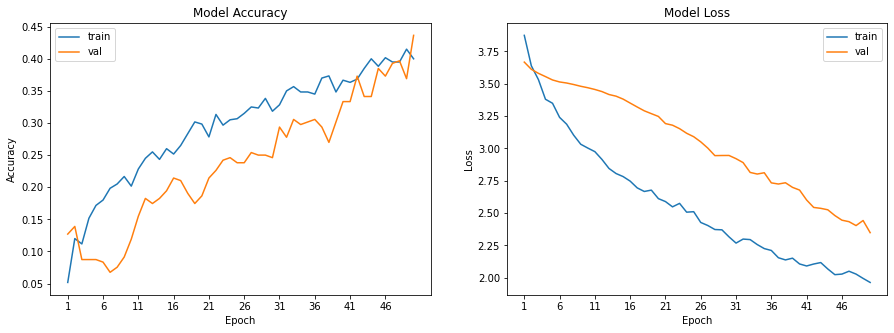

Training MLP took 110.7552490234375 seconds


In [8]:
model = build_model_v1()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Con capa de dropout pero sin batch normalization

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

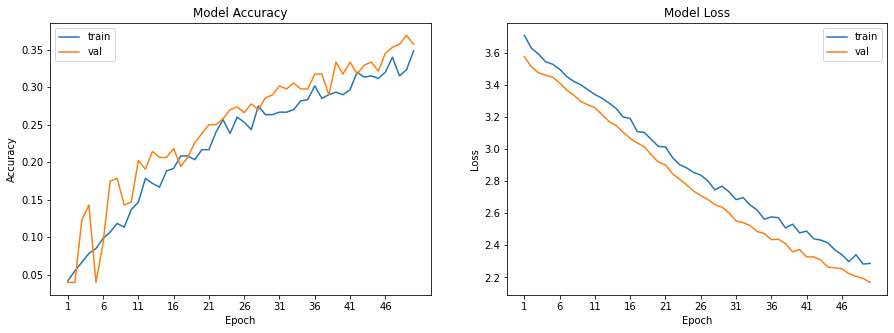

Training MLP took 107.47399950027466 seconds


In [9]:
model = build_model_v1(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Con capa de batch normalization pero sin dropout

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               19267712  
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)              

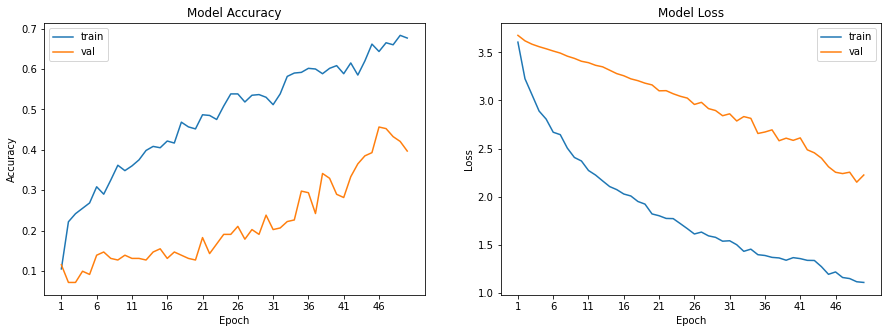

Training MLP took 108.8420000076294 seconds


In [10]:
model = build_model_v1(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Modelo ffNN 2
### Incluyendo capas de dropout y batch normalization

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_3 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_3 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_3 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               19267712  
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)              

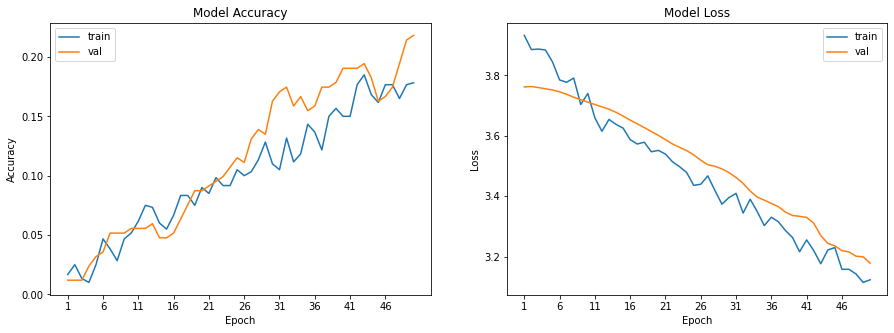

Training MLP took 108.94652581214905 seconds


In [11]:
model = build_model_v2()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de dropout, pero sin batch normalization

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_4 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_4 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_4 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               19267712  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)              

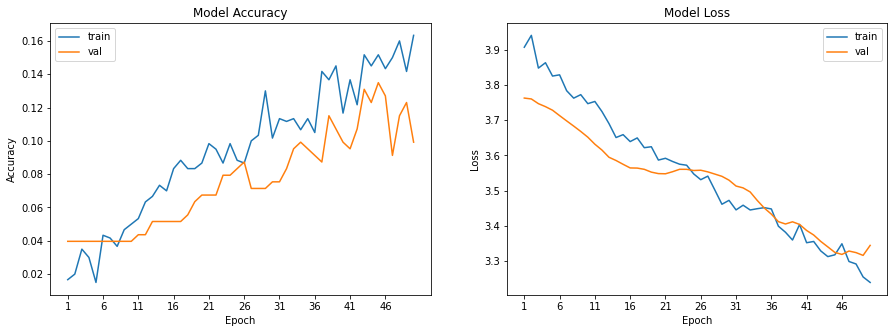

Training MLP took 118.84455013275146 seconds


In [12]:
model = build_model_v2(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de batch normalization, pero sin dropout

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_5 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_5 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_5 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               19267712  
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)              

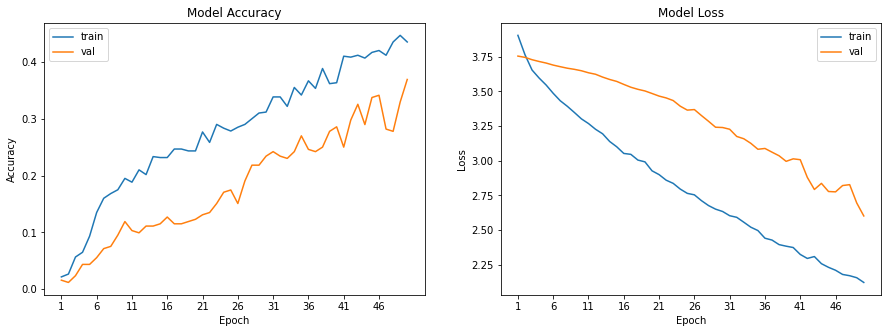

Training MLP took 132.61700129508972 seconds


In [13]:
model = build_model_v2(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Modelo ffNN 3
### Incluyendo capas de dropout y batch normalization

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_6 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_6 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_6 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              154141696 
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)             

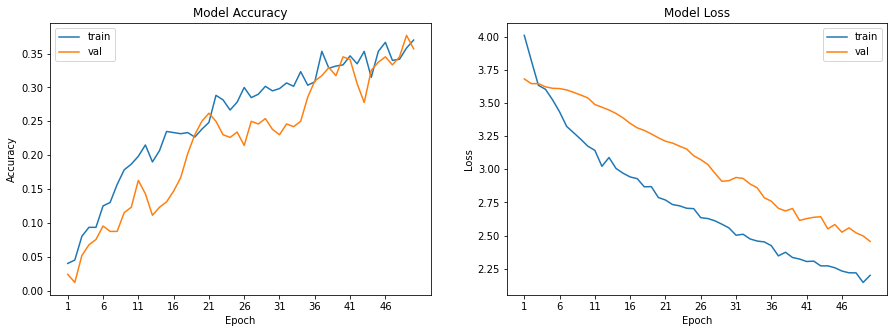

Training MLP took 257.35211753845215 seconds


In [14]:
model = build_model_v3()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de dropout, pero sin batch normalization

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_7 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_7 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_7 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_7 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 1024)              154141696 
_________________________________________________________________
dropout_16 (Dropout)         (None, 1024)             

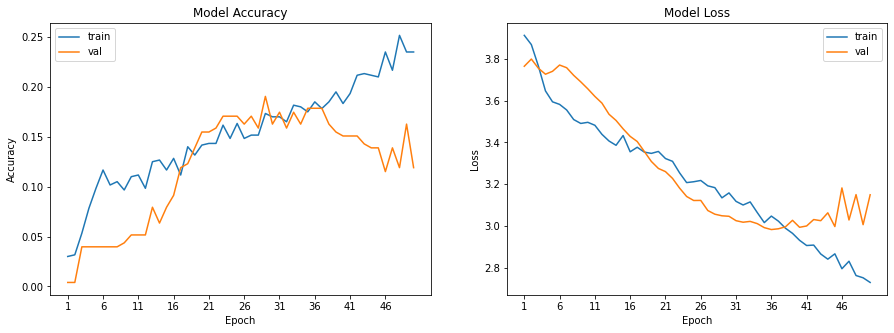

Training MLP took 323.27162981033325 seconds


In [15]:
model = build_model_v3(bn=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Incluyendo capas de batch normalization, pero sin dropout

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
random_rotation_8 (RandomRot (None, 224, 224, 3)       0         
_________________________________________________________________
random_zoom_8 (RandomZoom)   (None, 224, 224, 3)       0         
_________________________________________________________________
random_flip_8 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              154141696 
_________________________________________________________________
batch_normalization_18 (Batc (None, 1024)             

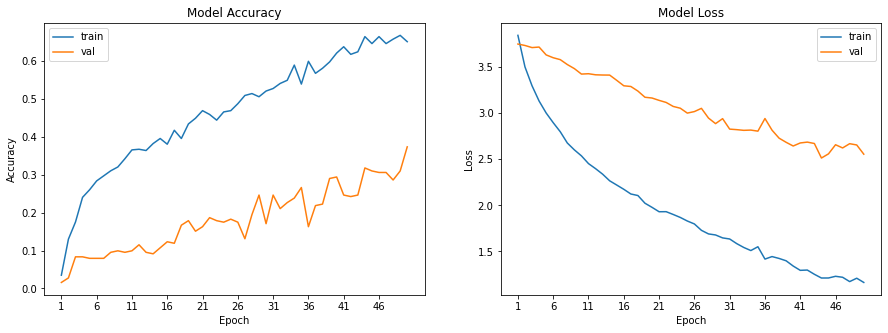

Training MLP took 333.2249093055725 seconds


In [16]:
model = build_model_v3(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
import time
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=128, epochs=50, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Red convolucional 1
En la experimentación con la red neuronal hay muchas variables que afectan al desempeño:
- Incluir capa de dropout o no
- Incluir capa de batch normalization antes o despues de la de activación, o simplemente no inlcuirla
- Incluir una capa extra o no.
Para no perder eficiencia del modelo se comprobó su desempeño con casi todas las combinaciones de configuraciones posibles (se excluyeron aquellas en las que no hay capa de dropout ni capa de batch normalization). Para entender en cada sección de esta experimentación que configuración tiene el modelo entrenado se incluye en el titulo de la sección los valores que toman cada una de las 3 variables mencionadas.

### dropput=si, batch_normalization=despues, capa_extra=no

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_22 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_39 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_40 (Activation)   (None, 224, 224, 32)      0     

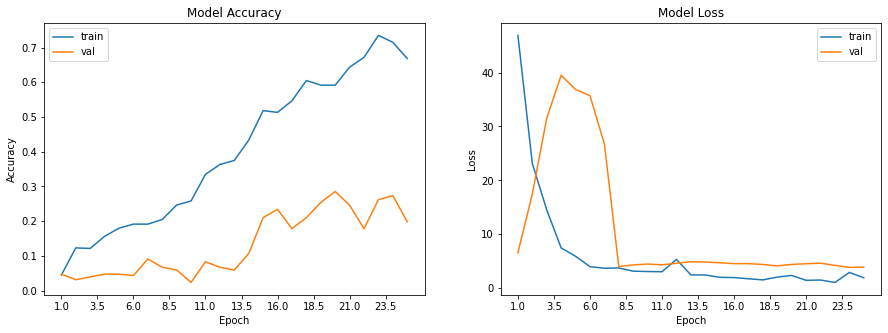

Training MLP took 3729.8447465896606 seconds


In [17]:
import keras.backend as K
import time

model = build_conv1(dout=True, bn=True, bn_before=True, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=antes, capa_extra=no

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_45 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_46 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 224, 224, 32)      128 

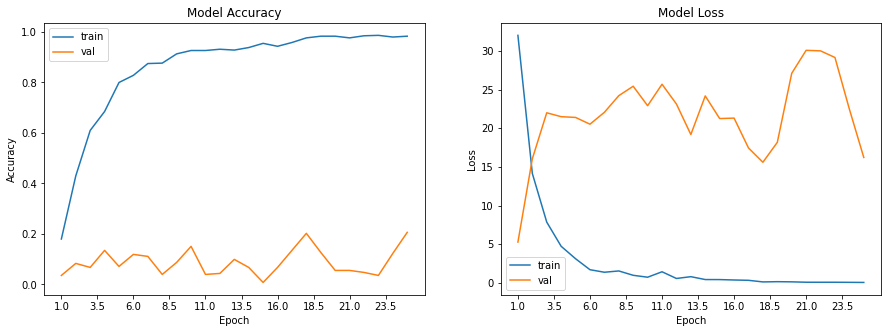

Training MLP took 3754.773003578186 seconds


In [18]:
model = build_conv1(dout=True, bn=True, bn_before=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=no, capa_extra=no

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_51 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_52 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 112, 112, 32)      0   

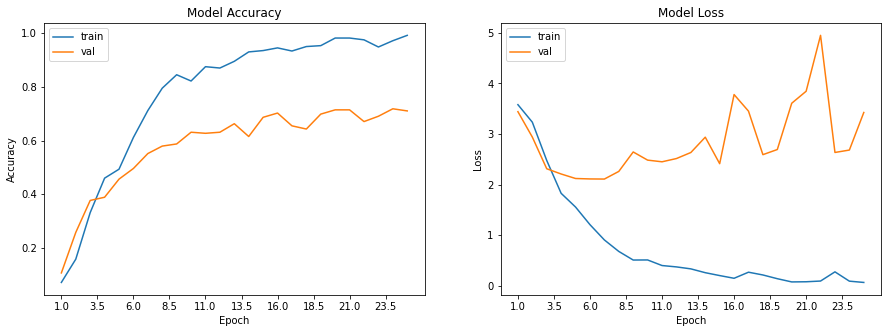

Training MLP took 1774.8370342254639 seconds


In [19]:
model = build_conv1(dout=True, bn=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=despues, capa_extra=no

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_34 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_57 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_58 (Activation)   (None, 224, 224, 32)      0   

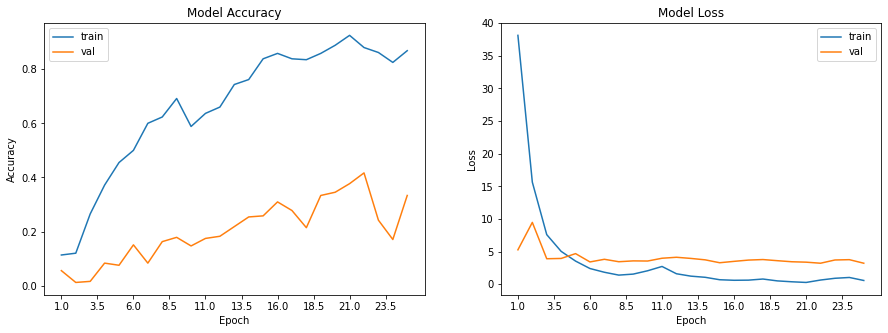

Training MLP took 3674.4543533325195 seconds


In [20]:
model = build_conv1(dout=False, bn=True, bn_before=True, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=antes, capa_extra=no

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_63 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_64 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 224, 224, 32)      128 

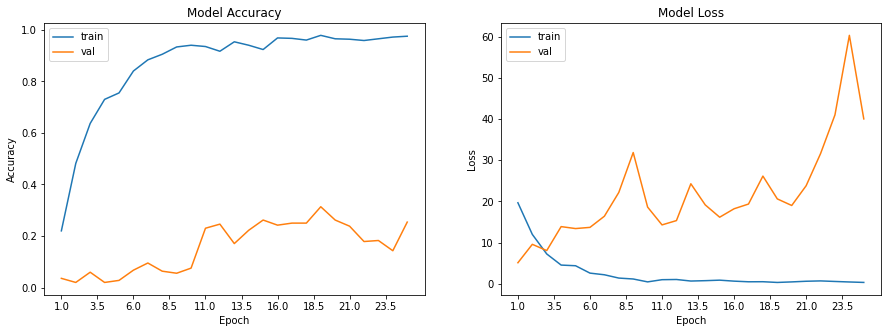

Training MLP took 3258.853638648987 seconds


In [21]:
model = build_conv1(dout=False, bn=True, bn_before=False, extra_layer=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=despues, capa_extra=si

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_46 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_69 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_47 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_70 (Activation)   (None, 224, 224, 32)      0   

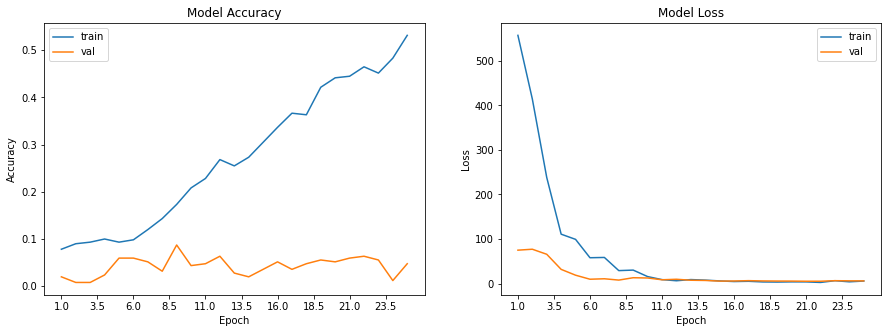

Training MLP took 2613.2958614826202 seconds


In [22]:
model = build_conv1(dout=True, bn=True, bn_before=True, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=antes, capa_extra=si

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_75 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_52 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_76 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_53 (Batc (None, 224, 224, 32)      128 

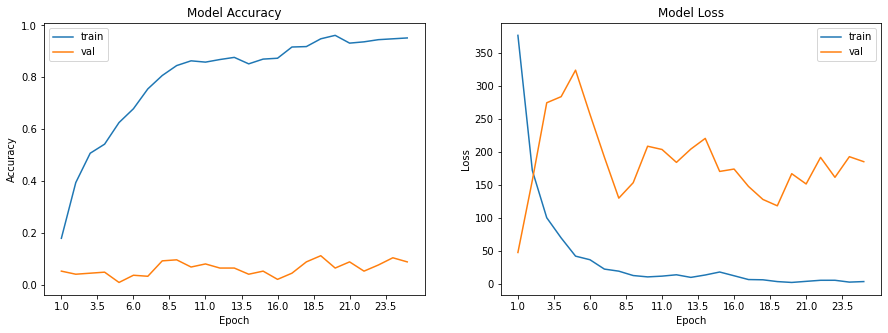

Training MLP took 2503.4007790088654 seconds


In [23]:
model = build_conv1(dout=True, bn=True, bn_before=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=si, batch_normalization=no, capa_extra=si


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_81 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_82 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 112, 112, 32)      0   

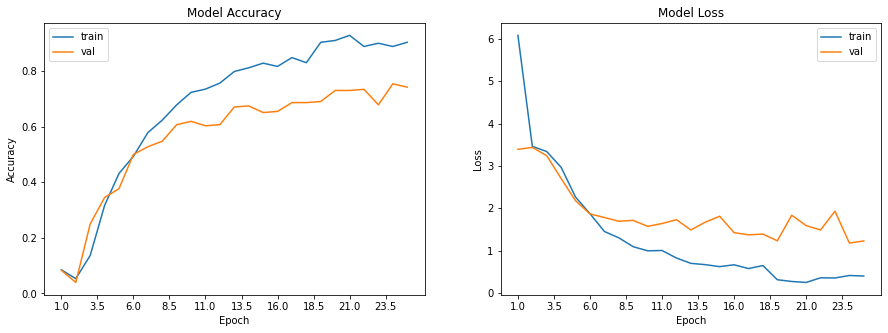

Training MLP took 1349.293954372406 seconds


In [24]:
model = build_conv1(dout=True, bn=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=despues, capa_extra=si

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_58 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_87 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_59 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation_88 (Activation)   (None, 224, 224, 32)      0   

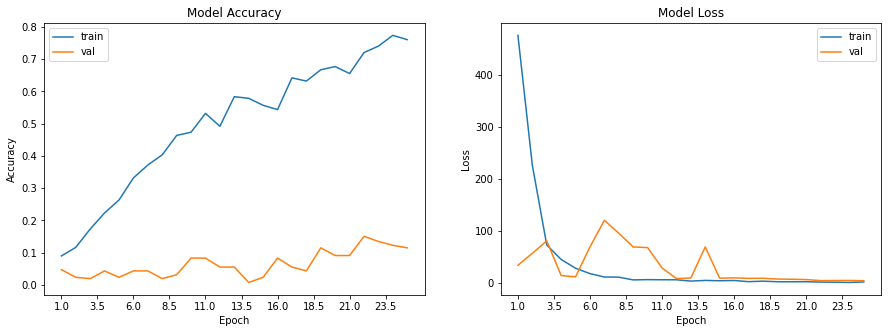

Training MLP took 2508.0708498954773 seconds


In [25]:
model = build_conv1(dout=False, bn=True, bn_before=True, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### dropput=no, batch_normalization=antes, capa_extra=si

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
activation_93 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
activation_94 (Activation)   (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 224, 224, 32)      128 

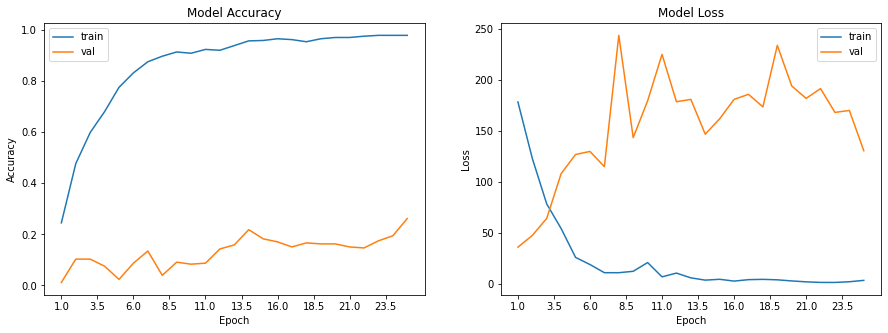

Training MLP took 2435.328405857086 seconds


In [26]:
model = build_conv1(dout=False, bn=True, bn_before=False, extra_layer=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

## Red convolucional 2
Esta red esta tomada del articulo "Multi-column deep neural network for traffic sign classification" de Ciresan et al. (2012)

### Con dropout

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 100)       14800     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 100)       0         
_________________________________________________________________
activation_12 (Activation)   (None, 24, 24, 100)      

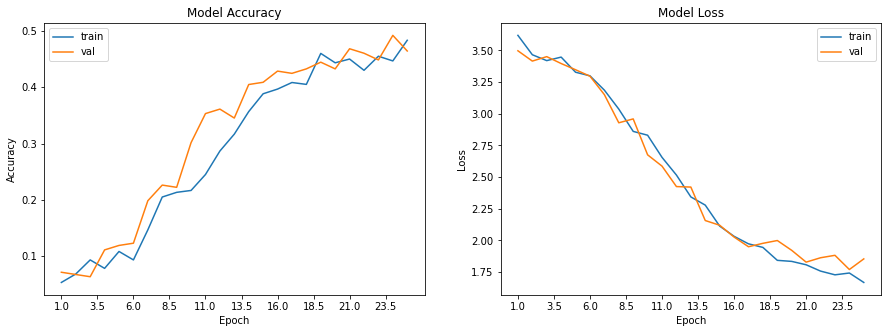

Training MLP took 126.89660501480103 seconds


In [23]:
import time
model = build_conv2(dout=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs_res, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs_res, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs_res, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")

### Sin dropout

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 48, 48, 3)         0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 48, 48, 3)         0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 48, 48, 3)         0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 100)       14800     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 100)       0         
_________________________________________________________________
activation_15 (Activation)   (None, 24, 24, 100)      

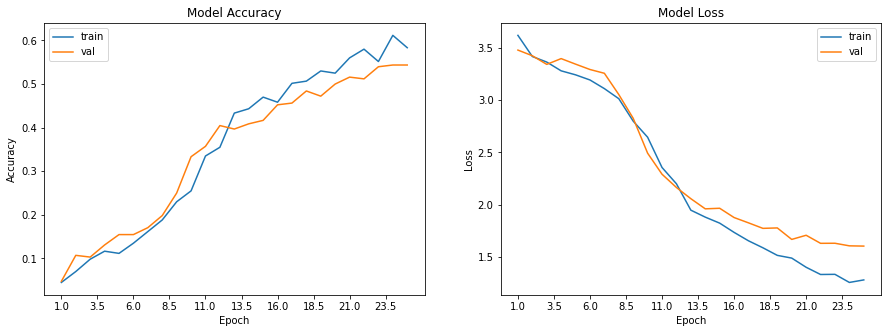

Training MLP took 128.7254650592804 seconds


In [24]:
model = build_conv2(dout=False)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Training
start = time.time()
history = model.fit(tr_signs_res, tr_labels, batch_size=64, epochs=25, verbose=1, validation_data=(va_signs_res, va_labels))
end = time.time()

loss, acc = model.evaluate(te_signs_res, te_labels, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', acc)

plot_model_history(history)
print("Training MLP took " + str(end - start) + " seconds")